## Functional annotation of MAGs against CAZy

This notebook is part of the analysis of the MAGs. 

## How to run Jupyter notebooks in huginn
<details>
<summary>Click to expand!</summary>

If you use vs-code you can use the [remote ssh extension](https://marketplace.visualstudio.com/items?itemName=ms-vscode-remote.remote-ssh) to connect to huginn and either run jupyterlab in the remote server (so to say, just like you would do in your local computer with `jupyter-lab`) or run directly without opening jupyterlab directly. 

Otherwise, you can follow the instructions below: 

1. Turn on VPN
2. Open two terminals (let's called A and B)
3. With terminal A, connect to huginn with ssh as usual
```bash
ssh username@huginn.au.dk
```
4. Move to the directory where you want to work, activate the conda enviroment and run jupyter notebook or jupyter lab:
```bash
conda activate jupyter-diamond
jupyter notebook --no-browser --port=7777
```
5. With terminal B, connect to huginn and forward the port specified port to your local computer
```bash
ssh -Y -N -L localhost:7777:localhost:7777 username@huginn.au.dk
```
6. Open your browser and go to `localhost:7777` and you should see the jupyter notebook running in huginn. You can also press in the url of Terminal A. 

Troubleshooting:
- If you get an error like `bind: Address already in use` it means that you have another jupyter notebook running in the same port. You can either kill the process or change the port.
</details>

## How to create a new environment for this notebook (if needed)

We will use Diamond, a few python basic libraries and bash. Let's check if those dependencies are installed. If not, you can install them with mamba (as well with jupyterlab)

```bash
# To create a new environment with mamba
mamba create -c bioconda -c conda-forge diamond pandas matplotlib jupyterlab -n jupyter-diamond
# To activate the environment
conda activate jupyter-diamond
```

### Sanity check

In [35]:
%%bash
diamond --version
python -c "import pandas; print(pandas.__version__)"
python -c "import matplotlib; print(matplotlib.__version__)"
bash --version | head -n 1

diamond version 2.1.8
1.1.5
3.3.4
GNU bash, version 4.4.20(1)-release (x86_64-pc-linux-gnu)


In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import os

The input is the fasta file with contigs and the count table. 

In [37]:
fasta_file = "../data/mags.fasta"
count_table = "../data/mags.tsv"
## Sanity check: fasta and count table exit
assert os.path.exists(fasta_file), "Fasta file does not exist"
assert os.path.exists(count_table), "Count table does not exist"

## Run Diamond 

In [38]:
database = "/data_2/Databases/CAZy/CAZyDB.07312019.dmnd"
descriptions_tsv = "/data_2/Databases/CAZy/CAZyDB.07302020.fam-activities.tsv"
outfile_matches = "../results/CAZy_matches_mags.tsv"

In [39]:
%%bash
mkdir -p ../results/

**Please, be aware that, without using any sensitivity option, the default mode is designed for finding hits of >60% identity. Consider increasing the sensitivity (or decreasing it).**

In [40]:
%%bash -s "$database" "$fasta_file" "$outfile_matches"
if [ ! -f $3 ]; then
diamond blastx -p 50 -d $1 -q $2 -o $3 2> /dev/null
fi
head $3

bin_37.fasta_02940	NP_176949.1|GH0|3.2.1.51	40.8	120	71	0	781	1140	178	297	1.38e-21	99.8


## Parse Diamond output and preprocess

In [41]:
diamond = pd.read_csv(
    outfile_matches,
    delimiter="\t",
    comment="#",
    header=None,
    names=[
        "Query id",
        "Subject id",
        "% identity",
        "alignment length",
        "mismatches",
        "gap openings",
        "q. start",
        "q. end",
        "s. start",
        "s. end",
        "e-value",
        "score",
    ],
)

Now, we have a table with all the alignments between our "genes" and the database.

In [42]:
diamond

,Query id,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
0,bin_37.fasta_02940,NP_176949.1|GH0|3.2.1.51,40.8,120,71,0,781,1140,178,297,1.380000e-21,99.8


## Read count table
However, we also need to read the count table:

In [43]:
%%bash -s "$count_table"
head $1

ContigID	ika_mgs_val_2	ika_mgs_val_1
bin_37.fasta_02940	31	30
bin_36.fasta_03910	123	129
bin_11.fasta_01027	88	97
bin_1.fasta_02543	25	21
bin_71.fasta_02748	93	92
bin_3.fasta_02341	43	47
bin_38.fasta_03427	12	13

In [44]:
counts = pd.read_csv(count_table, sep="\t", comment="#").set_index("ContigID")
# Check that there are only 2 columns
assert counts.shape[1] == 2, "Count table should have 2 columns"
# Sum the counts for each MAG
counts = counts.sum(axis=1)
# Convert to a dataframe
counts = pd.DataFrame(counts, columns=["Count"])
counts

,Count
ContigID,
bin_37.fasta_02940,61
bin_36.fasta_03910,252
bin_11.fasta_01027,185
bin_1.fasta_02543,46
bin_71.fasta_02748,185
bin_3.fasta_02341,90
bin_38.fasta_03427,25


## Preprocessing
### Most significant hit per Contig

Now, we need to get the most significant hit per each contig ID. Let's inspect how many hits there are per contig (adjust the number of bins). 

Text(0.5, 1.0, 'Number of hits per contig')

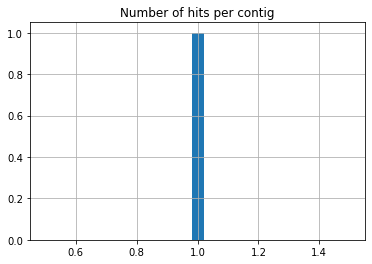

In [45]:
diamond.pivot_table(columns=["Query id"], aggfunc="size").hist(bins=25)
plt.title("Number of hits per contig")

In this case, we are going to sort rows per e-value and score and get the most significant hit per each ContigId.

In [46]:
diamond = (
    diamond.sort_values(by=["e-value", "score"], ascending=[True, False])
    .drop_duplicates("Query id", keep="first")
    .set_index("Query id")
)
diamond

,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
Query id,,,,,,,,,,,
bin_37.fasta_02940,NP_176949.1|GH0|3.2.1.51,40.8,120,71,0,781,1140,178,297,1.380000e-21,99.8


### Inspect E-values from aligned orthologous genes before filtering by e-value

array([[<AxesSubplot:title={'center':'e-value'}>]], dtype=object)

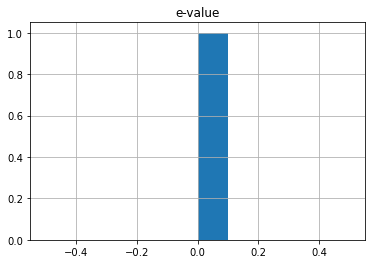

In [47]:
diamond.hist("e-value")

### Inspect E-values from aligned orthologous genes after filtering by e-value

We need to set a threshold:

In [48]:
evalue_threshold = 0.0001

In [49]:
diamond = diamond.loc[diamond["e-value"] < evalue_threshold]

array([[<AxesSubplot:title={'center':'e-value'}>]], dtype=object)

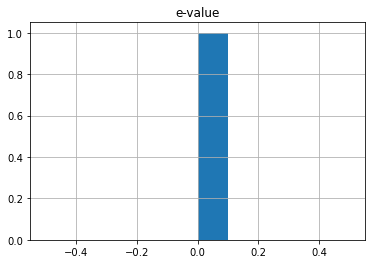

In [50]:
diamond.hist("e-value")

In [51]:
val = len(set(diamond["Subject id"]))
print(f"There are {val} unique orthologous genes")

There are 1 unique orthologous genes


### Inspect % identity and aligment length

array([[<AxesSubplot:title={'center':'alignment length'}>]], dtype=object)

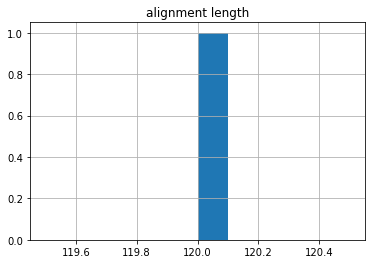

In [52]:
diamond.hist("alignment length")

array([[<AxesSubplot:title={'center':'% identity'}>]], dtype=object)

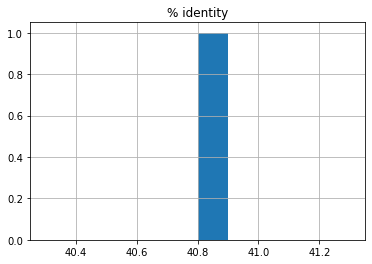

In [53]:
diamond.hist("% identity")

In [54]:
diamond

,Subject id,% identity,alignment length,mismatches,gap openings,q. start,q. end,s. start,s. end,e-value,score
Query id,,,,,,,,,,,
bin_37.fasta_02940,NP_176949.1|GH0|3.2.1.51,40.8,120,71,0,781,1140,178,297,1.380000e-21,99.8


Text(0, 0.5, 'Mistmatches')

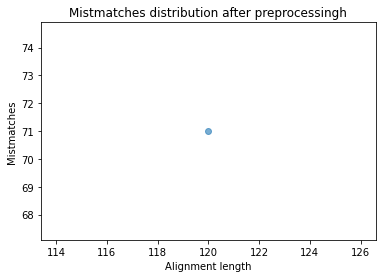

In [55]:
plt.scatter(diamond["alignment length"], diamond.mismatches, alpha=0.6)
plt.title("Mistmatches distribution after preprocessingh")
plt.xlabel("Alignment length")
plt.ylabel("Mistmatches")

## Attention !!
Please, consider the previous information to set the threshold for the e-value and the % identity.

### Merging aligned genes and count table
First, we are going to drop all columns except for ContigsID and orthologous genes header (to obtain map table). 

In [56]:
map_table = diamond[["Subject id"]]
map_table

,Subject id
Query id,
bin_37.fasta_02940,NP_176949.1|GH0|3.2.1.51


Now, we create an extra column with the bin name.

In [57]:
# Get everything before first '.'
map_table['bin'] = map_table.index.str.split(".").str[0] 
map_table

/software/anaconda3/envs/jupyter-diamond/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Subject id,bin
Query id,,
bin_37.fasta_02940,NP_176949.1|GH0|3.2.1.51,bin_37


Now, we are going to merge both files by their column in common (ContigID and Subject id).

In [58]:
df = pd.merge(map_table, counts, left_index=True, right_index=True).reset_index(
    drop=True
)
df

,Subject id,bin,Count
0,NP_176949.1|GH0|3.2.1.51,bin_37,61


Finally, we are going to make the table wider (from long format to wide format) and fill the empty values with 0. 

In [59]:
df_transformed = df.pivot_table(index='Subject id', columns='bin', values='Count', fill_value=0, aggfunc='sum')
df_transformed.reset_index(inplace=True)
df_transformed.columns.name = None
# Arrange columns so Subject id is first, then sort
df_transformed = df_transformed[["Subject id"] + sorted(df_transformed.columns[1:])]
df_transformed


,Subject id,bin_37
0,NP_176949.1|GH0|3.2.1.51,61


## Annotating count table

First, we define some helper functions:

In [60]:
import re
import doctest


def extract_CAZyDB_id(x: str):
    """
    >>> extract_CAZyDB_id('XP_503149.1|GH18')
    ['GH18']
    >>> extract_CAZyDB_id('AAA52077.1|CBM8|3.2.1.4')
    ['CBM8']
    >>> extract_CAZyDB_id('AAA52077.1|CBM8|3.2.1.4|GH18')
    ['CBM8', 'GH18']
    """
    return [elm for elm in x.split("|")[1:] if not re.match(r"^\d", elm)]


def get_annotation_from_CAZyDB_id(x: str):
    """
    >>> get_annotation_from_CAZyDB_id('GH31')
    'Glycoside Hydrolases'
    >>> get_annotation_from_CAZyDB_id('GT75')
    'GlycosylTransferases'
    >>> get_annotation_from_CAZyDB_id('AA5')
    'Auxiliary Activities'
    >>> get_annotation_from_CAZyDB_id('QAT16263.1')
    ''
    """
    symbols = {
        "GH": "Glycoside Hydrolases",
        "GT": "GlycosylTransferases",
        "PL": "Polysaccharide Lyases",
        "CE": "Carbohydrate Esterases",
        "AA": "Auxiliary Activities",
        "CBM": "Carbohydrate-Binding Modules",
    }
    for k in symbols.keys():
        regex = "^" + k
        if re.match(regex, x):
            return symbols[k]
    return ""


# Run tests
doctest.testmod()

TestResults(failed=0, attempted=7)

In [61]:
df_transformed["CAZyDB_id"] = [[y for y in extract_CAZyDB_id(x) if y] for x in df_transformed["Subject id"]]
df_transformed

,Subject id,bin_37,CAZyDB_id
0,NP_176949.1|GH0|3.2.1.51,61,[GH0]


Now, we want to extend the table by using the CAZyDB_id column (which is a list of list). Every row will have one CAZyDB_id.

In [62]:
df_transformed = df_transformed.explode("CAZyDB_id")
df_transformed

,Subject id,bin_37,CAZyDB_id
0,NP_176949.1|GH0|3.2.1.51,61,GH0


Now we can annotate the count table:

In [63]:
df_transformed["Level1"] = [get_annotation_from_CAZyDB_id(elm) for elm in df_transformed.CAZyDB_id]
df_transformed

,Subject id,bin_37,CAZyDB_id,Level1
0,NP_176949.1|GH0|3.2.1.51,61,GH0,Glycoside Hydrolases


And now we add descriptions: 

In [64]:
# Force the tsv in descriptions_tsv to have two columns
descriptions = pd.read_csv(
    descriptions_tsv, sep="\t", comment="#", header=None, names=["CAZyDB_id", "Level2"]
)
descriptions

,CAZyDB_id,Level2
0,AA0,
1,AA10,AA10 (formerly CBM33) proteins are copper-de...
2,AA11,AA11 proteins are copper-dependent lytic pol...
3,AA12,The pyrroloquinoline quinone-dependent oxido...
4,AA13,AA13 proteins are copper-dependent lytic pol...
...,...,...
441,PL5,"alginate lyase (EC 4.2.2.3); endo-beta-1,4-g..."
442,PL6,alginate lyase (EC 4.2.2.3); chondroitinase ...
443,PL7,poly(beta-mannuronate) lyase / M-specific al...
444,PL8,hyaluronate lyase (EC 4.2.2.1); chondroitin ...


In [65]:
# Rename subject id to ContigID
df_transformed = df_transformed.rename(columns={"Subject id": "ContigID"})
# Add the description to the dataframe
df_transformed = pd.merge(df_transformed, descriptions, on="CAZyDB_id", how="left")
df_transformed

,ContigID,bin_37,CAZyDB_id,Level1,Level2
0,NP_176949.1|GH0|3.2.1.51,61,GH0,Glycoside Hydrolases,Glycoside hydrolases not yet assigned to a f...


Now, we are going to count the number of enzymes with more than one annotation:

In [66]:
duplicated = (
    df_transformed.groupby("ContigID")
    .agg(
        Level1=("Level1", lambda x: "|".join(set(x))),
        types_of_annotation=("Level1", "nunique"),
        n_cazy_ids=("CAZyDB_id", "nunique"),
    )
    .reset_index()
    .loc[lambda x: x.n_cazy_ids > 1]
    .set_index("ContigID")
)
duplicated.to_csv("../results/CAZy_multiple_annotations_mags.tsv", sep="\t")
duplicated

,Level1,types_of_annotation,n_cazy_ids
ContigID,,,


In [67]:
df_transformed

,ContigID,bin_37,CAZyDB_id,Level1,Level2
0,NP_176949.1|GH0|3.2.1.51,61,GH0,Glycoside Hydrolases,Glycoside hydrolases not yet assigned to a f...


In [68]:
df_transformed.to_csv("../results/CAZy_matches_annotated_mags.tsv", sep="\t", index=False)